# Лабораторная работа 2

### Цель: предсказывать факт выживания на корабле Титаник
### Задачи

* Провести визуальный анализ данных
* Выбрать и обосновать метрику качества, попробовать несколько алгоритмов. Оптимизировать KNN в соответствии с метрикой
* Сохранить данные в pickle

Выполним действия по подготовке данных из ЛР 1:

In [1]:
#импорт необходимых модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Абсолютный путь до папки с данными
dataPath = '/home/alex/Downloads/bmstuML/dataMl/'

# читаем файл с данными для обучения
dataTrain = pd.read_csv(dataPath + 'train.csv',sep=',')
dataTrain = dataTrain.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis='columns') # не имеют логического обоснования
dataTrain =  dataTrain.drop(['Pclass'], axis='columns') # из-за корреляции


def replace_sex(sex):
    if sex == 'female':
        return 0
    return 1

dataTrain["Sex"] = dataTrain['Sex'].apply(replace_sex)


def oneHotEncoding(data, columnKey, rowKey):
    addList = []
    for index, row in data.iterrows():
        if row[columnKey] == rowKey:
            addList.append(1)
        else:
            addList.append(0)
    data['is_'+ rowKey] = addList

oneHotEncoding(dataTrain, 'Embarked','S')
oneHotEncoding(dataTrain, 'Embarked','C')
oneHotEncoding(dataTrain, 'Embarked','Q')
      
dataTrain = dataTrain.drop(['Embarked'], axis='columns')


# удаляем всех без возраста
dataTrain = dataTrain[dataTrain['Age'].notna()]



# тестовые данные без результата
dataTest = pd.read_csv(dataPath + 'test.csv',sep=',')

# добавим результат в тест данные (так проще обрабатывать)
dataTestResult = pd.read_csv(dataPath + 'gender_submission.csv',sep=',')
dataTest['Survived'] = dataTestResult['Survived']

#dataTest['Id2'] = dataTestResult['PassengerId'] # было для сверки id пассажира

# обрабатываем тестовые данные также как и учебные
dataTest = dataTest.drop([ 'PassengerId','Name', 'Ticket', 'Cabin', 'Pclass'], axis='columns')

dataTest["Sex"] = dataTest['Sex'].apply(replace_sex)

oneHotEncoding(dataTest,'Embarked','S')
oneHotEncoding(dataTest, 'Embarked','C')
oneHotEncoding(dataTest, 'Embarked','Q')
dataTest = dataTest.drop(['Embarked'], axis='columns')


dataTest = dataTest[dataTest['Age'].notna()]


dataTest = dataTest[dataTest['Fare'].notna()]


In [2]:
# выделяем целевую переменную и данные для обучения и тестов
y_train = dataTrain['Survived']
dataTrain = dataTrain.drop(['Survived'], axis='columns')
X_train = dataTrain


y_test = dataTest['Survived']
dataTest = dataTest.drop(['Survived'], axis='columns')
X_test = dataTest


#импорт класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)

# обучение
clf.fit(X_train, y_train)

# тест
clf.score(X_test, y_test)

0.6132930513595166

In [3]:
X_train.head(1)

,Sex,Age,SibSp,Parch,Fare,is_S,is_C,is_Q
0,1,22.0,1,0,7.25,1,0,0


### Корреляция

/home/alex/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sex', ylabel='count'>

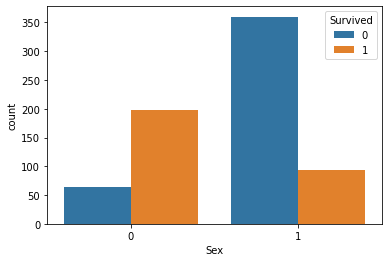

In [4]:
# смотрим кто выживал
sns.countplot(X_train['Sex'], hue=y_train)

Среди женщин выживших больше. Посмотрим корреляцию между величиными на графиках:

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


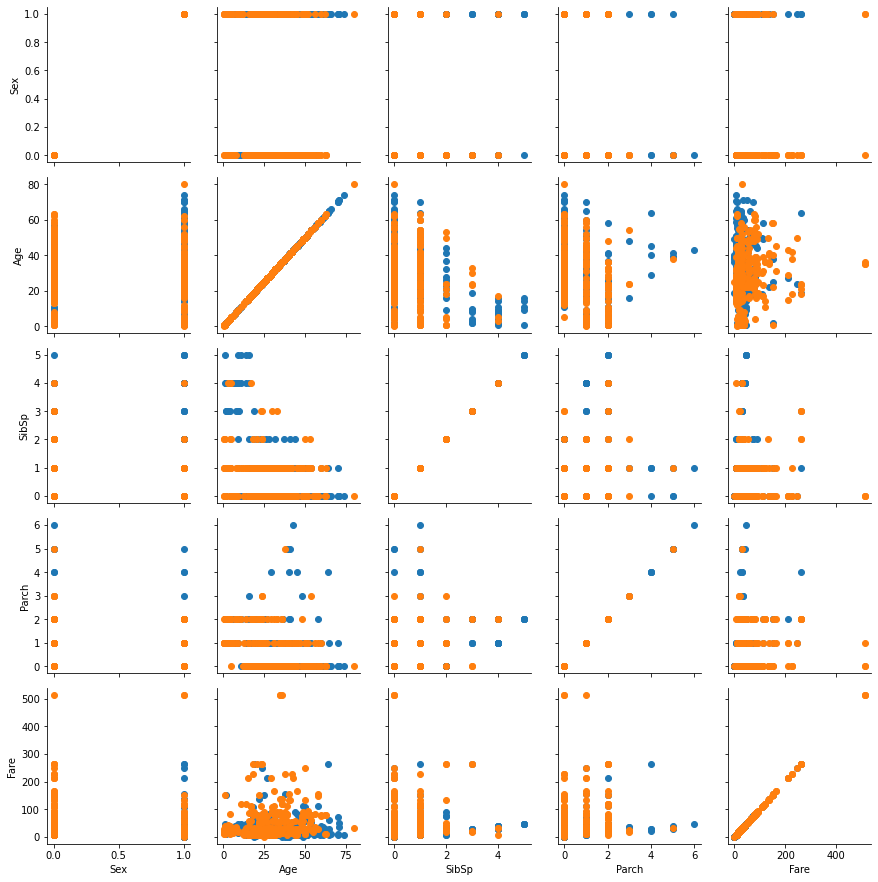

In [5]:
df_for_pairgrid = X_train[['Sex','Age','SibSp','Parch','Fare']]
df_for_pairgrid['Survived'] = y_train

sns.PairGrid(df_for_pairgrid, hue='Survived').map(plt.scatter)

### Медиана. Проверяем выбросы

<AxesSubplot:xlabel='Survived', ylabel='Age'>

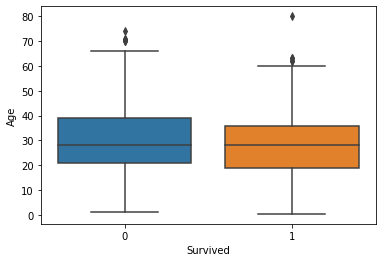

In [6]:
age = X_train['Age']
sns.boxplot(x=y_train, y = age)

<AxesSubplot:xlabel='Survived', ylabel='Age'>

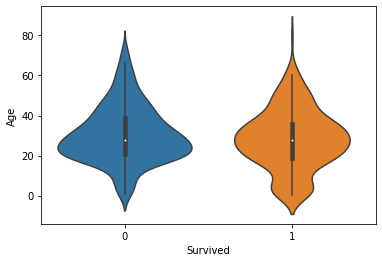

In [7]:
sns.violinplot(x=y_train, y = age)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

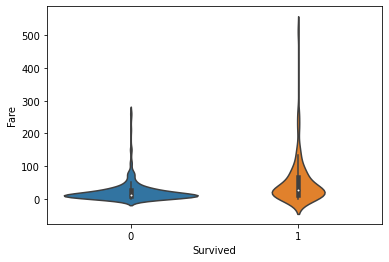

In [8]:
fare = X_train['Fare']
sns.violinplot(x=y_train, y = fare)

* Видим, что некоторым пассажирам с дорогими(~300) билетами не спаслись. Цена билета не являтся ключевым фактором. Возможно стоит выкинуть самых богатых людей из выборки, чтобы более удачно использовать вес цены билета и более удачно предсказывать шансы для большинства пассажиров.
* Огромная цена(~300) билета не всегда гарантирует спасение, но видно, что при смерти плотность у дешевых билетов больше.

### Нормализация

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

neighbors_count = 15

print('Before scale:', KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train,), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test,), columns=X_test.columns)


print('After scale:', KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))



Before scale: 0.595166163141994
After scale: 0.9486404833836858


* Нормализация оказала огромное влияние на результат, позволила достаточно точно предсказать результат на тест данных. С новой информацией вывод после 1 ЛР о том, что метод ближних соседей не является оптимальным для данной задачи, теряет свою актуальность.

* Графики:

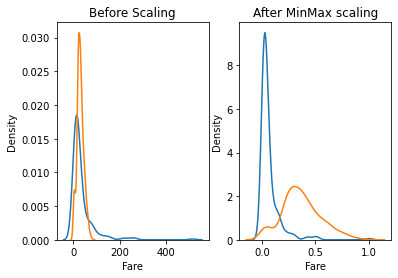

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.set_title('Before Scaling');
sns.kdeplot(X_train['Fare'], ax=ax1)
sns.kdeplot(X_train['Age'], ax=ax1)

ax2.set_title('After MinMax scaling');
sns.kdeplot(X_train_scaled['Fare'], ax=ax2)
sns.kdeplot(X_train_scaled['Age'], ax=ax2)

plt.show()

### Pipeline

Опишем функции и класс для использования в Pipeline(). 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


def replace_sex_value_pipe(sex):
    if sex == 'female':
        return 0
    return 1


def oneHotEncodingP(data, columnKey, rowKey):
    addList = []
    for index, row in data.iterrows():
        if row[columnKey] == rowKey:
            addList.append(1)
        else:
            addList.append(0)
    data['is_'+ rowKey] = addList



def delete_columns_pipe(data):
    data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Pclass'], axis='columns')
    return data


def replace_sex_pipe(data):
    data["Sex"] = data['Sex'].apply(replace_sex_value_pipe)
    return data
    


def one_hot_encode_embarked_pipe(data):
    data.head(1)
    oneHotEncodingP(data, 'Embarked','S')
    oneHotEncodingP(data, 'Embarked','C')
    oneHotEncodingP(data, 'Embarked','Q')
    data = data.drop(['Embarked'], axis='columns')
    return data


def delete_nan_age(data):
    data = data[data['Age'].notna()]
    return data
    

def delete_nan_fare(data):
    data = data[data['Fare'].notna()]
    return data

# все комментарии - это попытка избежать нормирования data['Survived']
# это не повлияло не результат, но ...
def scale_pipe(data):
    #saveSurvived = pd.DataFrame()
    #saveSurvived['Survived'] = data['Survived']
    #print('len(saveSurvived):',len(saveSurvived))
    #data = data.drop(['Survived'], axis='columns')
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data,), columns=data.columns)
    #saveSurvived.info()
    #data['Survived'] = saveSurvived['Survived']
    #data.info()
    # Почему сохраняются не все  data['Survived'] 
    return data
                         


class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self



# this pipeline has a single step
pipeline = Pipeline([
     ("удаляем колонки", DataframeFunctionTransformer(delete_columns_pipe)),
     ("меняем пол на 0 и 1", DataframeFunctionTransformer(replace_sex_pipe)),
     ("меняем представляем о порте в данных", DataframeFunctionTransformer(one_hot_encode_embarked_pipe)),
     ("удаляем всех без возраста", DataframeFunctionTransformer(delete_nan_age)),
     ("удаляем всех без цены", DataframeFunctionTransformer(delete_nan_fare)),
     ("нормализация", DataframeFunctionTransformer(scale_pipe)),
])



dataTrain = pd.read_csv(dataPath + 'train.csv',sep=',')

dataTest = pd.read_csv(dataPath + 'test.csv',sep=',')
# добавим результат в тест данные (так проще обрабатывать, перед обучением удалим)
dataTestResult = pd.read_csv(dataPath + 'gender_submission.csv',sep=',')
dataTest['Survived'] = dataTestResult['Survived']


dataTrain = pipeline.fit_transform(dataTrain)

dataTest = pipeline.fit_transform(dataTest);


y_train = dataTrain['Survived']
dataTrain = dataTrain.drop(['Survived'], axis='columns')
X_train = dataTrain


y_test = dataTest['Survived']
dataTest = dataTest.drop(['Survived'], axis='columns')
X_test = dataTest


neighbors_count = 15
print('After preparing pipeline:', KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train, y_train).score(X_test, y_test))


After preparing pipeline: 0.9486404833836858


### Сохранение данных в pickle

* Сохранним данные и проверим результат по ним до и после сохранения

In [12]:

trainDataPath = '/home/alex/Downloads/bmstuML/dataMl/trainData.plk'

testDataPath = '/home/alex/Downloads/bmstuML/dataMl/testData.plk'

X_train.to_pickle(trainDataPath) 
X_test.to_pickle(testDataPath) 

X_train = pd.read_pickle(trainDataPath)
X_test = pd.read_pickle(testDataPath)

neighbors_count =  15

# check result like step above
resultFromRead = KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train, y_train).score(X_test, y_test)
print('After read:', resultFromRead)

resultBeforeRead = KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train, y_train).score(X_test, y_test)
print('Same:', resultBeforeRead == resultFromRead)

After read: 0.9486404833836858
Same: True


### Подбор алгоритма

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

neighbors_count =  15

for clf in [DecisionTreeClassifier(), SGDClassifier(),SVC(), GaussianNB(), KNeighborsClassifier(n_neighbors = neighbors_count)]:
    print(clf.__class__.__name__, clf.fit(X_train, y_train).score(X_test, y_test))


DecisionTreeClassifier 0.7915407854984894
SGDClassifier 0.9758308157099698
SVC 0.9969788519637462
GaussianNB 0.8126888217522659
KNeighborsClassifier 0.9486404833836858


* Заметим, что лучший результат показал метод опорных векторов.

### Стратификация
Оценим насколько больше человек погибло чем выжило:

In [14]:
print(y_train.value_counts())

survived_count = y_train.gt(0.8).sum(axis=0)
dead_cound =  y_train.lt(0.8).sum(axis=0)

print('\nSurvived part:', survived_count/ (survived_count + dead_cound))
      

0.0    424
1.0    290
Name: Survived, dtype: int64

Survived part: 0.4061624649859944


Заметим, что соотношение 60/40%. Здесь нет явного преобладания одного значения, клонирование выживших для соотношения 50% на 50% не несет ощутимой пользы.

### Метрика качества
Посмотрим долю верных ответов (до этого смотрели её по умолчанию):

In [15]:
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=neighbors_count).fit(X_train, y_train)
y_test_my_result = clf.predict(X_test)


accuracy_score_result = accuracy_score(y_true=y_test, y_pred=y_test_my_result)

print('Accuracy score:', accuracy_score_result)

Accuracy score: 0.9486404833836858


Отметим, что accuracy сильно зависит от соотношения классов.

#### Задача 1

Допустим, что нам надо предсказать всех, кто погибнет. Критически нельзя пропустить пассажира и не предсказать ему смерть. Для этого воспользуемся метрикой recall = TP/(TP + FN). В таком случае задачу надо ставить так: recall -> 1, при precision не менее определенного значения. (Требование - предсказать ВСЕХ мертвых, не критично, если кто-то запишем в трупы, а он жив)

In [16]:
from sklearn.metrics import recall_score

rec_score = recall_score(y_true=y_test, y_pred=y_test_my_result)

print('Recall score:', rec_score)

Recall score: 0.937007874015748


#### Задача 2

Предположим другой вариант. Теперь нам у нас будет большая цена ошибки за предсказанную смерть живому челвоеку. (Допустим не хотим волновать ождающих родственников).В такой случае необходимо использовать precision = TP / (TP + FP)

In [17]:
from sklearn.metrics import precision_score

prec_score = precision_score(y_true=y_test, y_pred=y_test_my_result)

print('Precision score:', prec_score)

Precision score: 0.9296875


Выбор метрики зависит от задачи заказчика. Для случаев представленных выше требуются разные метрики. Есть метрика которая учитывает precision и recall в одной формуле - F-мера:

In [18]:

B_parameter = 0.5

F_score = (1 + B_parameter**2) * ( 2 * prec_score * rec_score) / (prec_score * B_parameter**2 + rec_score)

print('F_score(B=0.5)', F_score)

F_score(B=0.5) 1.8622848200312987


B_parameter принимает значения в диапазоне 0 < B_parameter < 1 если вы хотите отдать приоритет точности, а при B_parameter>1 приоритет отдается полноте

### Вывод
Был проведен визуальный анализ данных.Была сделана нормализация и просмотр данных на выбросы. Был использован Pipeline и Pickle для конвейерной обработки и сохранений данных. Для двух задач была выбрана и обоснована метрика. Наибольшее влияние на показатель метрики оказала нормализация данных.